## Image Generation using MNIST Dataset

This project involves training a neural network model from scratch on the MNIST dataset to generate fake handwritten images of digits from 0-9.

In [2]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

**Note: This is the only time the Keras library has been used in this notebook.**

## Loading the dataset

In [3]:
(train_images,train_labels),(test_images,test_labels)=mnist.load_data()

In [4]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Our training dataset consits of 60,000 images and the testing dataset consists of 10,000 images.

## Data Preprocessing

Data preprocessing involved normalizing the images and flattening them so that they can be used as input to the fully connected layers of the neural network. These steps are done to speed up training and improve model performance. In addition, the digit labels are converted into one hot encoded vectors.

In [5]:
# normalizing images
train_images=train_images/255.0
test_images=test_images/255.0

In [6]:
## flattening images( for fully connect layer of neural network)
train_images=train_images.reshape(train_images.shape[0],-1)
test_images=test_images.reshape(test_images.shape[0],-1)

In [7]:
# One-hot encoding of labels
num_classes=10
train_labels=np.eye(num_classes)[train_labels]
test_labels=np.eye(num_classes)[test_labels]

# Building the Neural Network

We'll create a simple neural network with one hidden layer.

## Helper Functions

First we define the activation and utility functions.

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

def dropout(x, drop_rate):
    mask = np.random.binomial(1, 1-drop_rate, size=x.shape) / (1-drop_rate)
    return x * mask

 The sigmoid function will be used in the output layer, the Relu function will be used in the hidden layer, the MSE function will be used for caluclating loss , the derivative of the loss function and ReLU will be used for back propogation.

## Neural Network Class

In [10]:
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.m_t = [np.zeros_like(self.weights_input_hidden), np.zeros_like(self.weights_hidden_output)]
        self.v_t = [np.zeros_like(self.weights_input_hidden), np.zeros_like(self.weights_hidden_output)]
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0

    def forward(self, x, drop_rate=0.5):
        self.hidden_input = np.dot(x, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = relu(self.hidden_input)
        self.hidden_output = dropout(self.hidden_output, drop_rate)
        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.final_output = sigmoid(self.final_input)
        return self.final_output
    
    def backward(self, x, y, output, learning_rate):
        self.t += 1
        output_error = mse_loss_derivative(y, output)
        output_delta = output_error * sigmoid(output)
        
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * relu_derivative(self.hidden_output)
        
        self.weights_hidden_output -= self.adam_update(self.weights_hidden_output, np.dot(self.hidden_output.T, output_delta), 1, learning_rate)
        self.bias_output -= learning_rate * np.sum(output_delta, axis=0, keepdims=True)
        self.weights_input_hidden -= self.adam_update(self.weights_input_hidden, np.dot(x.T, hidden_delta), 0, learning_rate)
        self.bias_hidden -= learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)
    
    def adam_update(self, weights, grad, idx, lr):
        self.m_t[idx] = self.beta1 * self.m_t[idx] + (1 - self.beta1) * grad
        self.v_t[idx] = self.beta2 * self.v_t[idx] + (1 - self.beta2) * np.square(grad)
        
        m_t_corr = self.m_t[idx] / (1 - np.power(self.beta1, self.t))
        v_t_corr = self.v_t[idx] / (1 - np.power(self.beta2, self.t))
        
        return lr * m_t_corr / (np.sqrt(v_t_corr) + self.epsilon)
    
    def train(self, x, y, epochs, learning_rate):
        loss_history = []
        for epoch in range(epochs):
            output = self.forward(x)
            self.backward(x, y, output, learning_rate)
            loss = mse_loss(y, output)
            loss_history.append(loss)
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')
        return loss_history

# Define the network parameters
input_size = 10
hidden_size = 128  # Increased hidden layer size
output_size = 784

We intitialize our network with an input layer,a hidden layer and an output layer. Weights are intialized to random,small values and biases were intialized as zeros. 

The forward propogation class computes the output of the hidden layer with ReLU activation and dropout.

The backward propogation class updates the weights and biases with the help of the Adam optimizer.

The train class trains our model over the specified number of epochs as well as stores the value of the loss function to monitor progress.

In the end we define the network parameters.


# Training the Neural Network

Our model is instantiated and trained over 10,000 epochs and the learning rate is set to 0.001

In [11]:
# Instantiate the neural network
nn = SimpleNN(input_size, hidden_size, output_size)

# Create training data for the neural network
x_train = np.eye(num_classes)
y_train = np.array([train_images[train_labels[:, i].astype(bool)][0] for i in range(num_classes)])

# Train the neural network
loss_history = nn.train(x_train, y_train, epochs=10000, learning_rate=0.001)


Epoch 0, Loss: 0.22928429717979393
Epoch 100, Loss: 0.12318914589198074
Epoch 200, Loss: 0.041854686244772524
Epoch 300, Loss: 0.028384321966163327
Epoch 400, Loss: 0.015355360829255437
Epoch 500, Loss: 0.009251616060799672
Epoch 600, Loss: 0.005977011582302201
Epoch 700, Loss: 0.00453316346938082
Epoch 800, Loss: 0.0032098944703798124
Epoch 900, Loss: 0.004380582196477523
Epoch 1000, Loss: 0.0029298901853856657
Epoch 1100, Loss: 0.0033103492429369277
Epoch 1200, Loss: 0.0037938841393938385
Epoch 1300, Loss: 0.0031095713254765114
Epoch 1400, Loss: 0.004019114299174214
Epoch 1500, Loss: 0.003049816408949848
Epoch 1600, Loss: 0.0037378322859673366
Epoch 1700, Loss: 0.0036949343948547183
Epoch 1800, Loss: 0.003001014193313364
Epoch 1900, Loss: 0.0036857389441747952
Epoch 2000, Loss: 0.0033003470467872307
Epoch 2100, Loss: 0.0019876292194129326
Epoch 2200, Loss: 0.0028348503159048057
Epoch 2300, Loss: 0.0040229589577418364
Epoch 2400, Loss: 0.0027341401239569835
Epoch 2500, Loss: 0.0029351

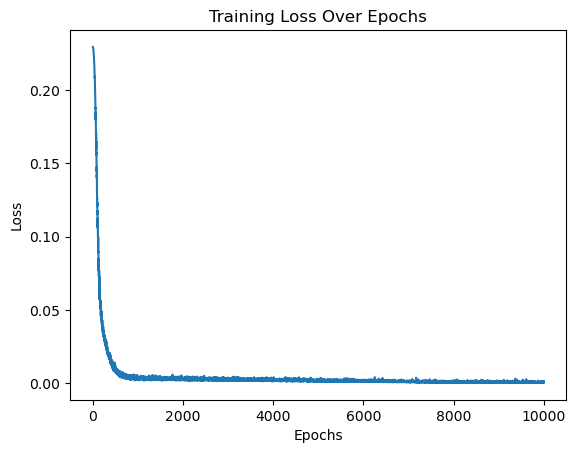

In [12]:
# Plot the training loss over epochs
plt.plot(range(10000), loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# Generating Images

Enter a digit (0-9) to generate its image: 8


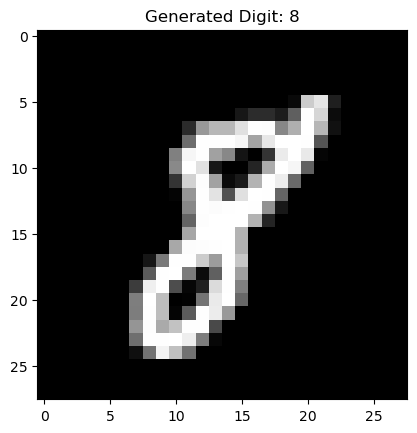

In [17]:
def generate_digit_image(digit):
    input_vector = np.zeros((1, num_classes))
    input_vector[0, digit] = 1
    generated_image = nn.forward(input_vector, drop_rate=0.0)  # No dropout during inference
    generated_image = generated_image.reshape(28, 28)
    
    plt.imshow(generated_image, cmap='gray')
    plt.title(f'Generated Digit: {digit}')
    plt.show()

# Example of generating an image for a specific digit
digit_to_generate = int(input("Enter a digit (0-9) to generate its image: "))
generate_digit_image(digit_to_generate)

Different images can be generated based on user input.